#### Average trade rate - new data
12.06.2023

In [122]:
# importing libraries
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# importing functions
from functions_v2 import *

# setting up filepaths (home_path is the path to the folder containing all use case folders)
home_path = r'C:\Users\weissflo\FIM Kernkompetenzzentrum\Projekt VIdES - General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\n'
results = r'C:\Users\weissflo\FIM Kernkompetenzzentrum\Projekt VIdES - General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\n\results'
tou_rate_dir = r'C:\Users\weissflo\FIM Kernkompetenzzentrum\Projekt VIdES - General\07_Arbeitsordner\02_Daten_und_Simulationsvorbereitung\ToU Tarife'

# setting up use case filepaths (e.g. use_case_0_dir_path is the path to the folder "use_case_0")
use_case_dir_paths = []
for root, dir, file in os.walk(top=home_path, topdown=True):
    use_case_dir_paths += [os.path.join(root, d) for d in dir if 'use_case_' in d[-10:]]
use_case_dir_paths = [i for i in use_case_dir_paths if not 'results\\' in i]
# Einkommentieren wenn UC 0 synchronisiert ist
# use_case_0_dir_path = [i for i in use_case_dir_paths if 'use_case_0' in i][0]
use_case_2_dir_path = [i for i in use_case_dir_paths if 'use_case_2' in i][0]
use_case_4_dir_path = [i for i in use_case_dir_paths if 'use_case_4' in i][0]
use_case_6_dir_path = [i for i in use_case_dir_paths if 'use_case_6' in i][0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
os.listdir(home_path)

['results', 'use_case_2', 'use_case_3', 'use_case_4', 'use_case_6']

---

##### Trade rate and trading volume: Data preparation
For each use case, collect low-level house files that contain hourly avg. trade rate and trading volume.
For each entity (house, wind, industry), concatenate all month files into one data frame.  
Result: A dataframe per use case (`df0`, `df2`, `df4`, `df6`) with the structure:
- rows: 4 weeks * 7 days * 24 hours (672 timesteps)
- cols: average trade rate and trading volume for an entity (in pairs of two)

In [123]:
# Avg. price houses: Read in all trade rates for each use case (takes 20min each!)
# avg_price_houses = avg_p_houses(use_case_0_dir_path)
# avg_price_houses.to_csv(os.path.join(results, 'use_case_0_avg_price_houses.csv'), index=True)
# avg_price_houses = avg_p_houses(use_case_2_dir_path)
# avg_price_houses.to_csv(os.path.join(results, 'use_case_2_avg_price_houses.csv'), index=True)
# avg_price_houses = avg_p_houses(use_case_4_dir_path)
# avg_price_houses.to_csv(os.path.join(results, 'use_case_4_avg_price_houses.csv'), index=True)
# avg_price_houses = avg_p_houses(use_case_6_dir_path)
# avg_price_houses.to_csv(os.path.join(results, 'use_case_6_avg_price_houses.csv'), index=True)


# Instead, read in the preprocessed csv files. Do not change any filepath here, only variable 'results' in the cell above!
def read_in_df(filepath):
    df = pd.read_csv(os.path.join(results, filepath), index_col=0).reset_index(drop=True)
    df = df.iloc[:,1:]
    return df
# df0 = read_in_df('use_case_0_avg_price_houses.csv')
df2 = read_in_df('use_case_2_avg_price_houses.csv')
df4 = read_in_df('use_case_4_avg_price_houses.csv')
df6 = read_in_df('use_case_6_avg_price_houses.csv')

---

##### Trade rate and trading volume: Data filtering
The following functions assume a dataframe with the structure described above. It is advised to only use a generic variable `df` for the functions, and assigning the desired use case dataframe to `df` before calling the functions. E.g. `df = df0` for use case 0. Then continue the analyis with `df`.  

The default dataframes contain all entities (houses, wind, and industry). For the analysis, we need to filter for the desired entities. This is done by selecting all columns that (don't) contain an **entity name**. For example:
- `df_industry = df[[i for i in df.columns.tolist() if 'industry' in i]]`: Industry only
- `df_wind = df[[i for i in df.columns.tolist() if 'wind' in i]]`: Wind only
- `df_houses = df[[i for i in df.columns.tolist() if not 'industry' in i if not 'wind' in i]]`: Houses only

The resulting (word filtered) dataframe e.g. `df_houses` still contains the average trade rate and trading volume in pairs of two for each entity. To get the trade rate and trading volume separately, we need to filter **for every second column**:
- `df_houses.iloc[:,0::2]`: Average trade rates for houses
- `df_houses.iloc[:,1::2]`: Trading volumes for houses

Finally, we have a dataframe with the desired entities (e.g. only houses) and metric (e.g. avg. trade rate). This dataframe has 672 rows (timesteps) and >400 columns (depending on the nr. of selected entities). We can now calculate the **average/sum** for both axes:
- `df_houses.iloc[:,0::2].mean(axis=0)`: Average trade rate per entity for all timesteps
- `df_houses.iloc[:,0::2].mean(axis=1)`: Average trade rate per timestep for all entities
- `df_houses.iloc[:,0::2].mean(axis=0).mean(axis=1)`: Average trade rate for all entities and timesteps

In [124]:
# define a function to calculate: trading quantity = trade volume / trade rate
def get_trade_quantity(df_word_filtered):
    newcols = [i.replace('trade volume [EURO ct.]', 'trade quantity [kWh]') for i in df_word_filtered.iloc[:,1::2].columns.tolist()]
    trade_rates = df_word_filtered.iloc[:,0::2].values
    trade_volumes = df_word_filtered.iloc[:,1::2].values
    trade_quantity = trade_volumes / trade_rates
    return pd.DataFrame(trade_quantity, columns=newcols).fillna(0.0)

# Example: Total trading quantity for industry in use case 2
df = df2
df_word_filtered = df[[i for i in df.columns.tolist() if 'industry' in i]]
print('Total trading quantity for industry in use case 2: ', get_trade_quantity(df_word_filtered).sum().sum(), 'kWh')

# Example: Minimum avg. trading rate for any household and timestep in use case 2
df = df2
df_word_filtered = df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]]
print('Minimum avg. trading rate for any household and timestep in use case 2: ', df_word_filtered.iloc[:,0::2].min().min(), 'ct./kWh')

Total trading quantity for industry in use case 2:  294153.3593920895 kWh
Minimum avg. trading rate for any household and timestep in use case 2:  0.203 ct./kWh


In [125]:
# Example: Avg. trading rate, avg. trading volume, and total trading quantity for industry in use case 6
df = df6
df_word_filtered = df[[i for i in df.columns.tolist() if 'industry' in i]]

print(f'avg. trading rate: {df_word_filtered.iloc[:,0::2].mean().mean()} ct./kWh')
print(f'avg. trading volume: {df_word_filtered.iloc[:,1::2].mean().mean()} ct.')
print(f'total trading quantity: {get_trade_quantity(df_word_filtered).sum().sum()} kWh')

avg. trading rate: 21.49802770337324 ct./kWh
avg. trading volume: 1578.377351027885 ct.
total trading quantity: 294153.3562211836 kWh


---

##### Trade rate and trading volume: Data visualization

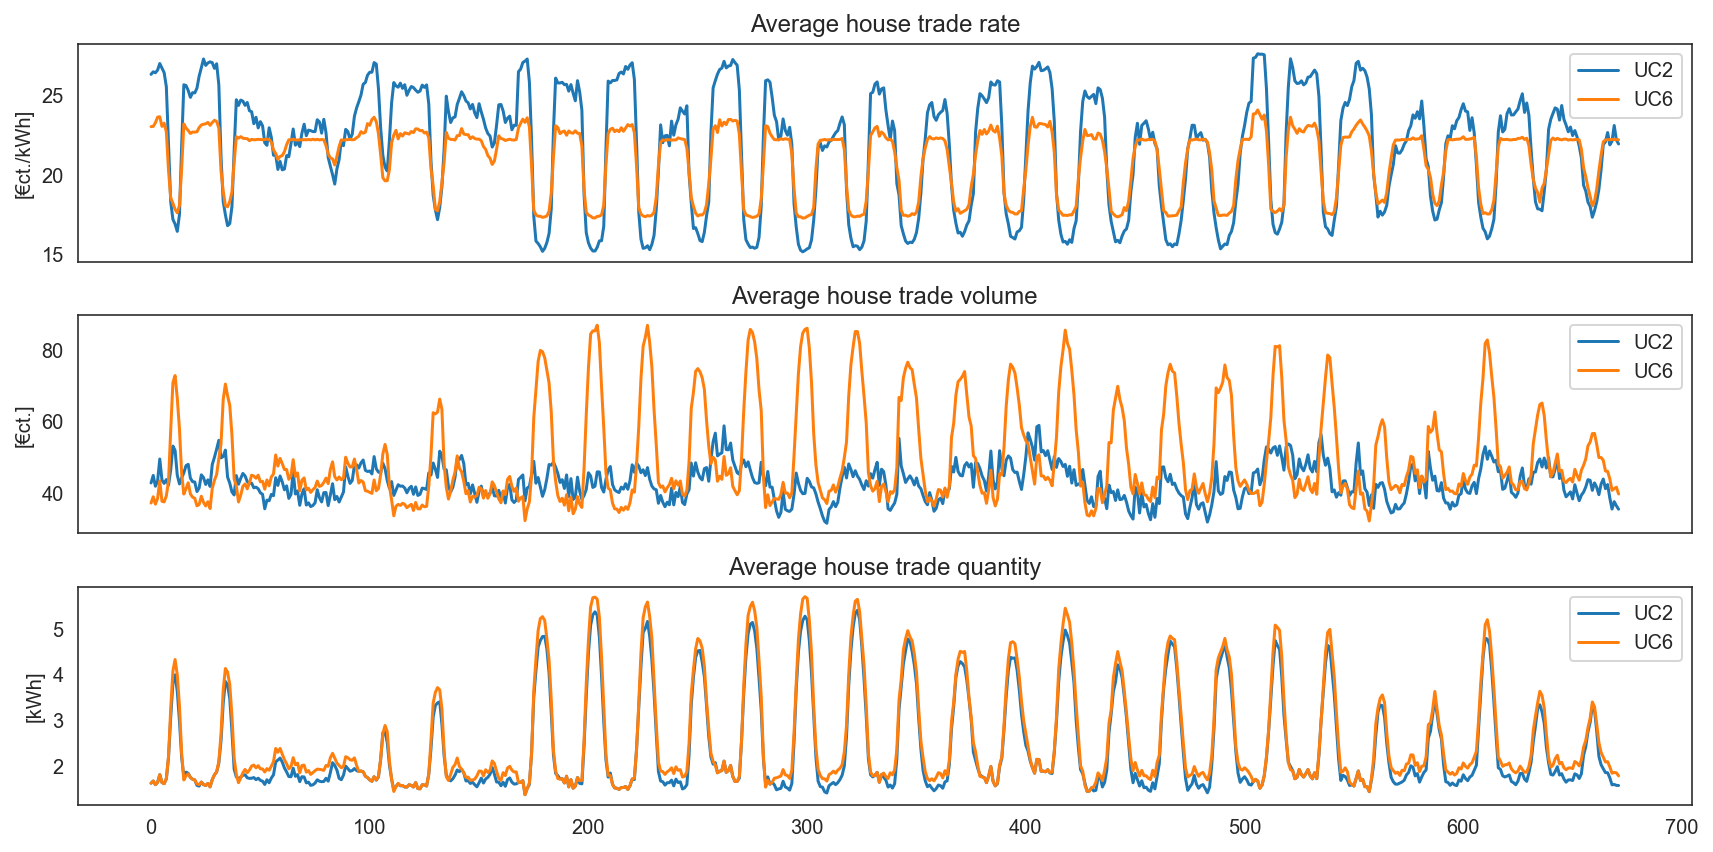

In [126]:
# Put all dataframes in 'dfs' that you want to plot on top of each other
dfs = {
    '2': df2,
    '6': df6
}

# Plotting
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(3,1, figsize=(12,6), sharex=True)

for key in dfs.keys():
    df = dfs[key]
    axs[0].plot(df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,0::2].mean(axis=1), label=f'UC{key}')
    axs[1].plot(df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,1::2].mean(axis=1), label=f'UC{key}')
    axs[2].plot(get_trade_quantity(df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]]).iloc[:,1::2].mean(axis=1), label=f'UC{key}')

axs[0].set_title('Average house trade rate')
axs[0].set_ylabel('[€ct./kWh]')
axs[1].set_title('Average house trade volume')
axs[1].set_ylabel('[€ct.]')
axs[2].set_title('Average house trade quantity')
axs[2].set_ylabel('[kWh]')

for ax in axs:
    ax.legend()
    
plt.tight_layout()
plt.show()

C:\Users\joche\AppData\Local\Temp\ipykernel_2344\2900970545.py:6: RuntimeWarning: invalid value encountered in true_divide
  trade_quantity = trade_volumes / trade_rates


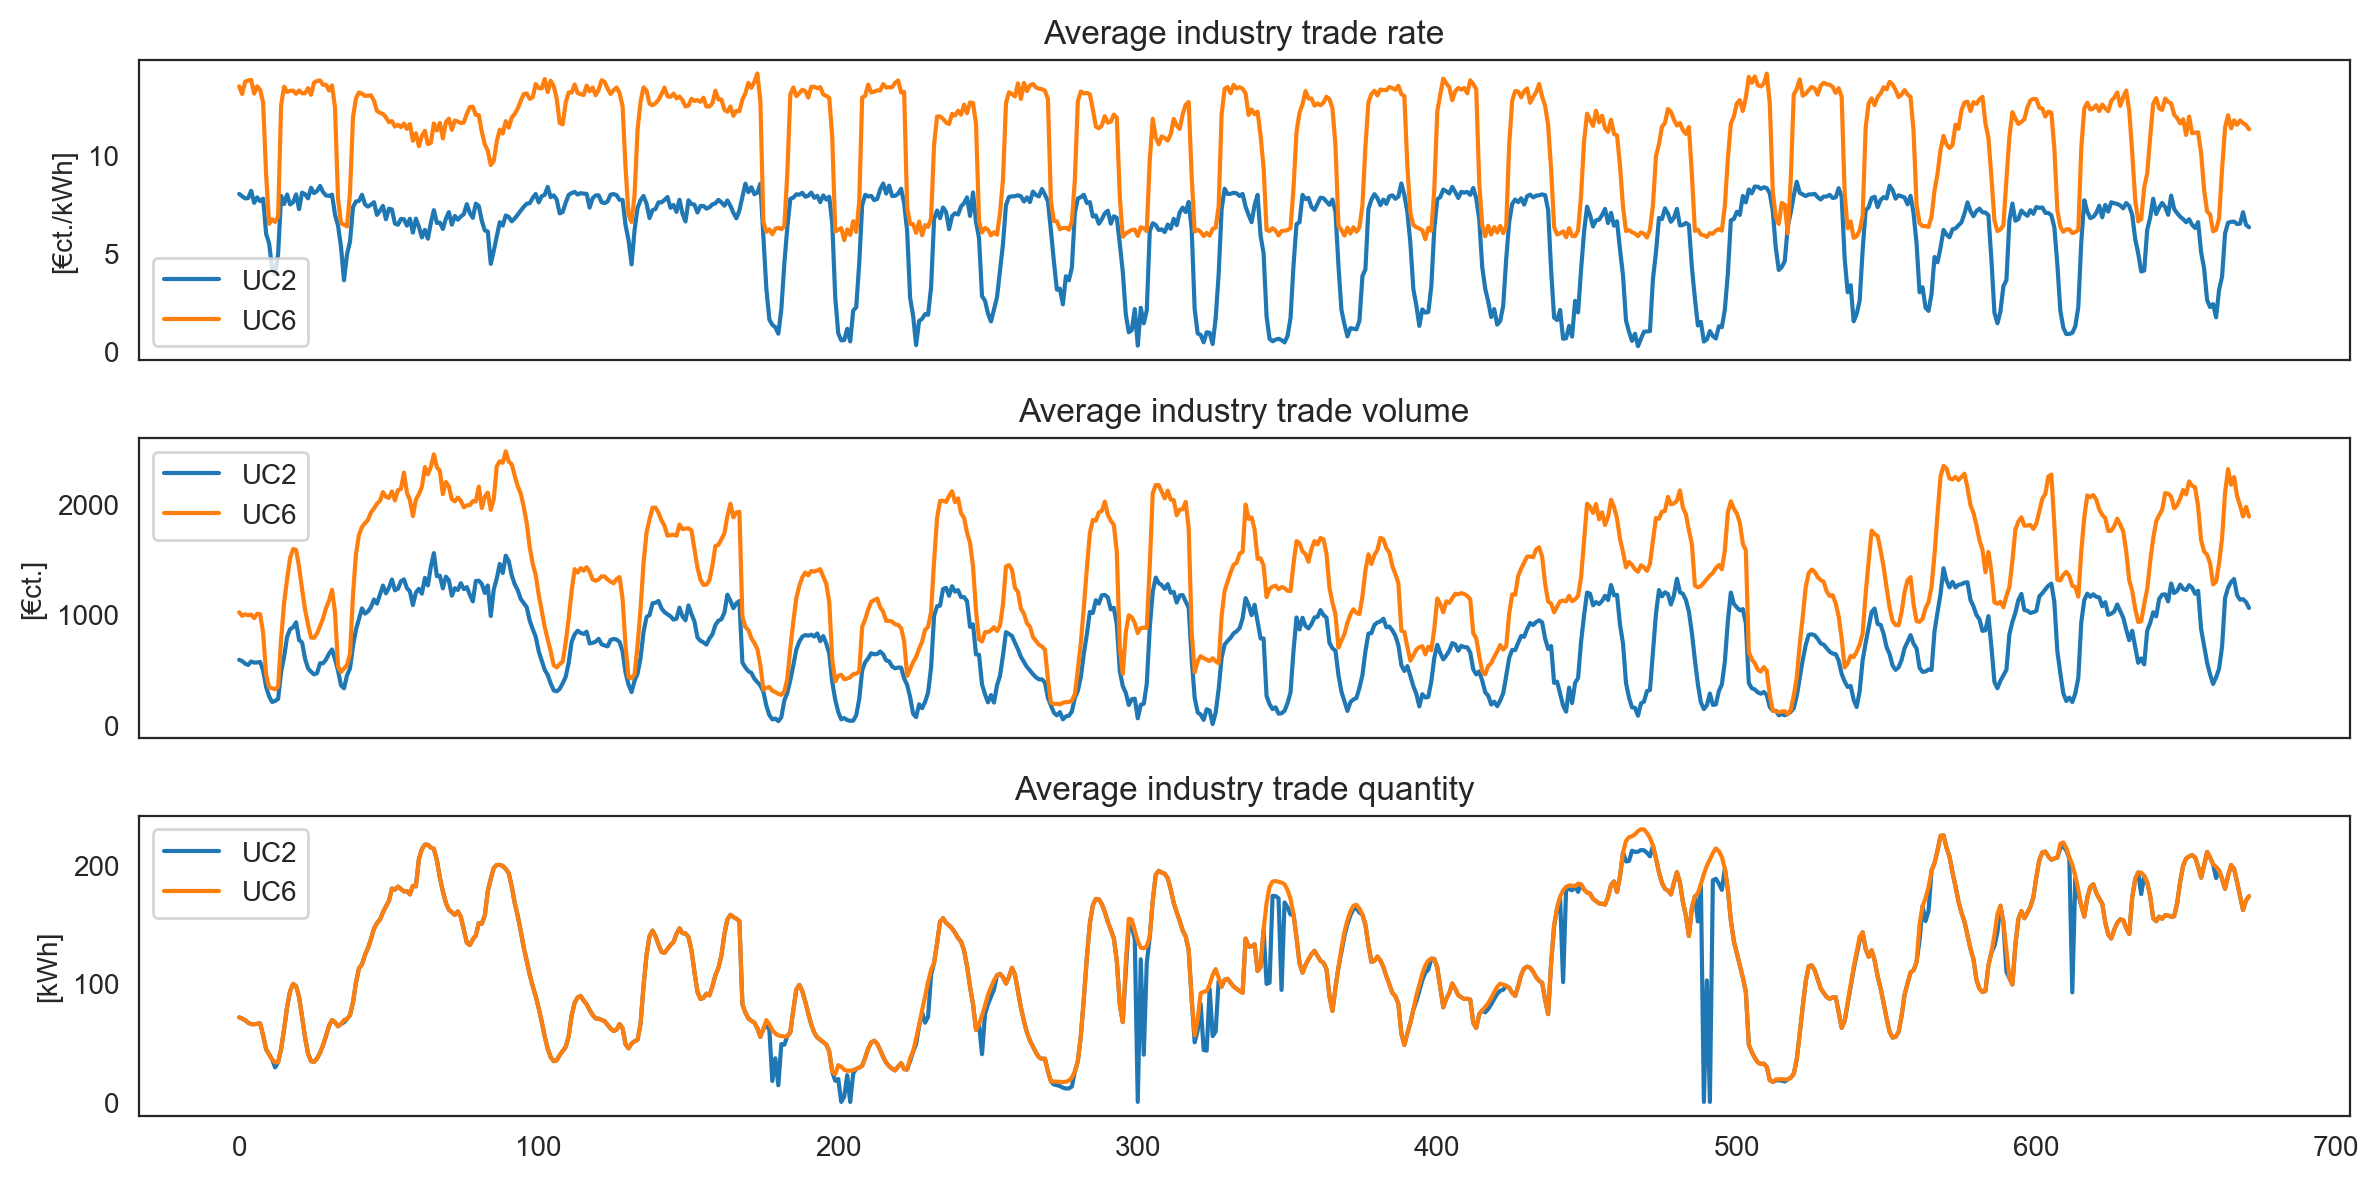

In [141]:
# Put all dataframes in 'dfs' that you want to plot on top of each other
dfs = {
    '2': df2,
    '6': df6
}

# Plotting
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(3,1, figsize=(12,6), sharex=True)

for key in dfs.keys():
    df = dfs[key]
    axs[0].plot(df[[i for i in df.columns.tolist() if 'wind' in i]].iloc[:,0::2].mean(axis=1), label=f'UC{key}')
    axs[1].plot(df[[i for i in df.columns.tolist() if 'wind' in i]].iloc[:,1::2].mean(axis=1), label=f'UC{key}')
    axs[2].plot(get_trade_quantity(df[[i for i in df.columns.tolist() if 'wind' in i]]).iloc[:,1::2].mean(axis=1), label=f'UC{key}')

axs[0].set_title('Average industry trade rate')
axs[0].set_ylabel('[€ct./kWh]')
axs[1].set_title('Average industry trade volume')
axs[1].set_ylabel('[€ct.]')
axs[2].set_title('Average industry trade quantity')
axs[2].set_ylabel('[kWh]')

for ax in axs:
    ax.legend()
    
plt.tight_layout()
plt.show()

C:\Users\joche\AppData\Local\Temp\ipykernel_2344\2900970545.py:6: RuntimeWarning: invalid value encountered in true_divide
  trade_quantity = trade_volumes / trade_rates
C:\Users\joche\AppData\Local\Temp\ipykernel_2344\2900970545.py:6: RuntimeWarning: invalid value encountered in true_divide
  trade_quantity = trade_volumes / trade_rates


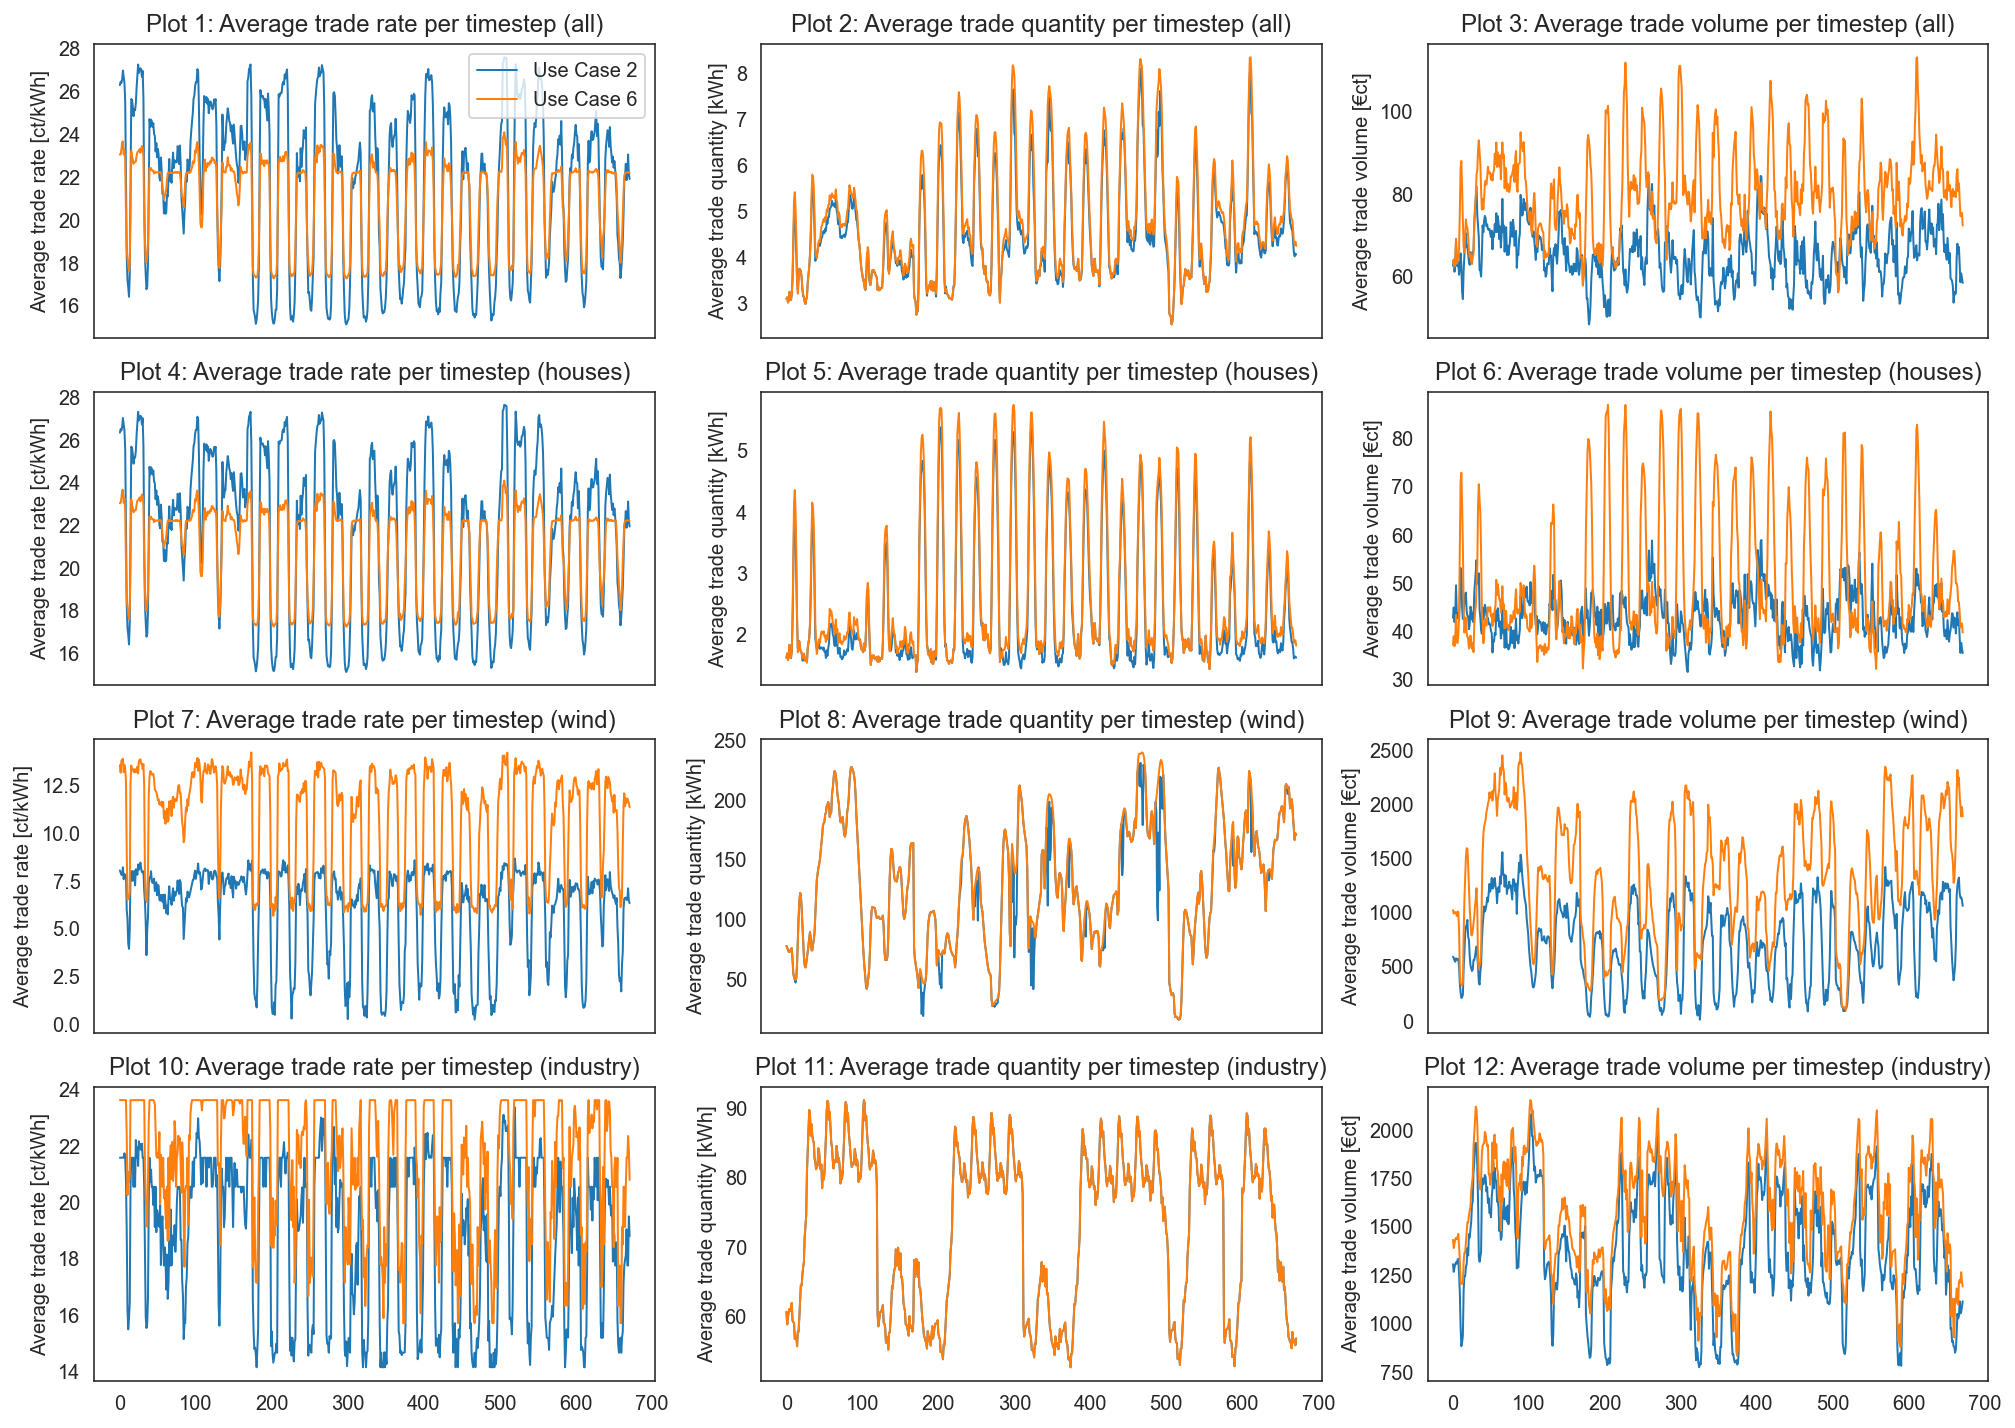

In [128]:
# Put all dataframes in 'dfs' that you want to plot on top of each other
df_dict = {
    '2': df2,
    '6': df6,
}

# create plotting function
def plot_rates_comparison(df_dict):
    fig, axs = plt.subplots(4, 3, figsize=(14,10), sharex=True)
    linewidth = 1.0

    # average trade rate (all)
    axs[0,0].set_title('Plot 1: Average trade rate per timestep (all)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[0,0].plot(df[[i for i in df.columns.tolist() if not 'wind' in i]].iloc[:,0::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[0,0].set_ylabel('Average trade rate [ct/kWh]')
    axs[0,0].legend()

    # average trading quantity (all)
    axs[0,1].set_title('Plot 2: Average trade quantity per timestep (all)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[0,1].plot(get_trade_quantity(df[[i for i in df.columns.tolist()]]).mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[0,1].set_ylabel('Average trade quantity [kWh]')

    # average trading volume (all)
    axs[0,2].set_title('Plot 3: Average trade volume per timestep (all)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[0,2].plot(df[[i for i in df.columns.tolist()]].iloc[:,1::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[0,2].set_ylabel('Average trade volume [€ct]')

    # average trade rate (houses)
    axs[1,0].set_title('Plot 4: Average trade rate per timestep (houses)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[1,0].plot(df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,0::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[1,0].set_ylabel('Average trade rate [ct/kWh]')

    # average trading quantity (houses)
    axs[1,1].set_title('Plot 5: Average trade quantity per timestep (houses)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[1,1].plot(get_trade_quantity(df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]]).mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[1,1].set_ylabel('Average trade quantity [kWh]')

    # average trading volume (houses)
    axs[1,2].set_title('Plot 6: Average trade volume per timestep (houses)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[1,2].plot(df[[i for i in df.columns.tolist() if not 'wind' in i if not 'industry' in i]].iloc[:,1::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[1,2].set_ylabel('Average trade volume [€ct]')

    # average trade rate (wind)
    axs[2,0].set_title('Plot 7: Average trade rate per timestep (wind)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[2,0].plot(df[[i for i in df.columns.tolist() if 'wind' in i]].iloc[:,0::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[2,0].set_ylabel('Average trade rate [ct/kWh]')

    # average trading quantity (wind)
    axs[2,1].set_title('Plot 8: Average trade quantity per timestep (wind)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[2,1].plot(get_trade_quantity(df[[i for i in df.columns.tolist() if 'wind' in i]]).mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[2,1].set_ylabel('Average trade quantity [kWh]')

    # average trading volume (wind)
    axs[2,2].set_title('Plot 9: Average trade volume per timestep (wind)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[2,2].plot(df[[i for i in df.columns.tolist() if 'wind' in i]].iloc[:,1::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[2,2].set_ylabel('Average trade volume [€ct]')

    # average trade rate (industry)
    axs[3,0].set_title('Plot 10: Average trade rate per timestep (industry)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[3,0].plot(df[[i for i in df.columns.tolist() if 'industry' in i]].iloc[:,0::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[3,0].set_ylabel('Average trade rate [ct/kWh]')

    # average trading quantity (industry)
    axs[3,1].set_title('Plot 11: Average trade quantity per timestep (industry)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[3,1].plot(get_trade_quantity(df[[i for i in df.columns.tolist() if 'industry' in i]]).mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[3,1].set_ylabel('Average trade quantity [kWh]')

    # average trading volume (industry)
    axs[3,2].set_title('Plot 12: Average trade volume per timestep (industry)', fontsize=12)
    for i in df_dict.keys():
        df = df_dict[i]
        axs[3,2].plot(df[[i for i in df.columns.tolist() if 'industry' in i]].iloc[:,1::2].mean(axis=1), label=f'Use Case {i}', linewidth=linewidth)
    axs[3,2].set_ylabel('Average trade volume [€ct]')

    plt.tight_layout()
    return fig

# apply function
g = plot_rates_comparison(df_dict)

---

---

##### Total spent and earnt: Data preparation
For each use case, collect the corresponding `cumulative_bills.json` file. It contains a monthly financial summary for all entities. For each use case, concatenate all months into one data frame, creating an overall financial summary for all entities. The resulting dataframe has the structure:
- rows: `spent_total`, `earned`, and `total`
- cols: all entities, e.g. `Region_1_EC1_house_0`

The dataframes are stored as:
- `cum_bills_uc2`: Use case 2
- `cum_bills_uc6`: Use case 6

In [129]:
def tot_cost_helper(use_case_home_path):
    # get all relevant file paths
    all_filepaths, all_filenames = [], []
    for root, dir, file in os.walk(top=use_case_home_path, topdown=True):
        all_filepaths += [os.path.join(root, f) for f in file if 'cumulative_bills.json' in f]
    # read in all months' files, group by agent_name and sum up total cost
    months_dfs = []
    for i in all_filepaths:
        df_month = pd.read_json(i, orient='index')[['name', 'spent_total', 'earned', 'total']]
        months_dfs.append(df_month)

    # filter for households, industry, and wind
    df_out = pd.concat(months_dfs).groupby('name', as_index=True).sum().T
    df_out = df_out[[i for i in df_out.columns.tolist() if 'house' in i]]
    
    return df_out

# get total entity cost for each use case
cum_bills_uc0 = tot_cost_helper(use_case_0_dir_path)
cum_bills_uc2 = tot_cost_helper(use_case_2_dir_path)
cum_bills_uc6 = tot_cost_helper(use_case_6_dir_path)


# show example cum_bills_uc2
cum_bills_uc2

name,Region_1_EC0_house_Wind,Region_1_EC1_house_0,Region_1_EC1_house_1,Region_1_EC1_house_10,Region_1_EC1_house_11,Region_1_EC1_house_12,Region_1_EC1_house_13,Region_1_EC1_house_14,Region_1_EC1_house_15,Region_1_EC1_house_16,...,Region_6_EC4_house_2,Region_6_EC4_house_20,Region_6_EC4_house_3,Region_6_EC4_house_4,Region_6_EC4_house_5,Region_6_EC4_house_6,Region_6_EC4_house_7,Region_6_EC4_house_8,Region_6_EC4_house_9,Region_6_EC5_house_Industry
spent_total,0.00,135.868,134.554,153.966,182.852,180.978,186.865,166.459,700.82,229.734,...,127.971,426.916,589.107,127.981,130.52,653.358,95.816,633.311,174.635,9446.282
earned,7361.05,0.000,0.000,0.000,0.000,0.000,0.000,513.494,0.00,342.980,...,206.694,0.000,199.216,99.237,0.00,0.000,0.000,0.000,0.000,0.000
total,-7361.05,135.868,134.554,153.966,182.852,180.978,186.865,-347.035,700.82,-113.246,...,-78.723,426.916,389.891,28.742,130.52,653.358,95.816,633.311,174.635,9446.282


In [20]:
cum_bills_uc4

name,Region_1_EC0_house_Wind,Region_1_EC1_house_0,Region_1_EC1_house_1,Region_1_EC1_house_10,Region_1_EC1_house_11,Region_1_EC1_house_12,Region_1_EC1_house_13,Region_1_EC1_house_14,Region_1_EC1_house_15,Region_1_EC1_house_16,...,Region_6_EC4_house_2,Region_6_EC4_house_20,Region_6_EC4_house_3,Region_6_EC4_house_4,Region_6_EC4_house_5,Region_6_EC4_house_6,Region_6_EC4_house_7,Region_6_EC4_house_8,Region_6_EC4_house_9,Region_6_EC5_house_Industry
spent_total,0.0,149.527,158.817,164.828,209.873,204.331,196.242,185.464,787.682,272.652,...,136.542,468.425,675.446,145.008,145.88,755.893,107.591,739.634,192.864,12367.267
earned,0.0,0.000,0.000,0.000,0.000,0.000,0.000,509.399,0.000,370.370,...,164.402,0.000,179.630,76.833,0.00,0.000,0.000,0.000,0.000,0.000
total,0.0,149.527,158.817,164.828,209.873,204.331,196.242,-323.933,787.682,-97.718,...,-27.860,468.425,495.817,68.175,145.88,755.893,107.591,739.634,192.864,12367.267


---

##### Total spent and earnt: Data filtering
It is advised to only use a generic variable `df` for the functions, and assigning the desired use case dataframe to `df` before calling the functions. E.g. `df = cum_bills_uc2` for use case 2. Then continue the analyis with `df`.

We again need to filter out the desired entities. This is done by selecting all columns that (don't) contain an entity name. For example (watch for the capitalization in Industry and Wind):
- `df_houses = df[[i for i in df.columns.tolist() if 'house' in i if not 'Wind' in i if not 'Industry' in i]]`: Houses only
- `df_wind = df[[i for i in df.columns.tolist() if 'Wind' in i]]`: Wind only
- `df_industry = df[[i for i in df.columns.tolist() if 'Industry' in i]]`: Industy only

Finally, we can select a metric (row) that interests us. For example:
- `df_industry.loc['spent_total']`: Total spent for each entity
- `df_industry.loc['earned']`: Total earned for each entity
- `df_industry.loc['total']`: Total earned - total spent for each entity

To get the total spent and earnt for all entities (e.g. industry), we can sum over the columns:
- `df_industry.loc['spent_total'].sum()`: Total spent for all entities
- `df_industry.loc['earned'].sum()`: Total earned for all entities
- etc.


In [130]:
# Example: Total of all three metrics for all industry entities in use case 2
df = cum_bills_uc2
df = df[[i for i in df.columns.tolist() if 'Industry' in i]]
print('spent: ', df.loc['spent_total'].sum())
print('earnt: ', df.loc['earned'].sum())
print('total: ', df.loc['total'].sum())

# Example: Total of all three metrics for all house entities in use case 6
df = cum_bills_uc6
df = df[[i for i in df.columns.tolist() if 'house' in i if not 'Wind' in i if not 'Industry' in i]]
print('spent: ', df.loc['spent_total'].sum())
print('earnt: ', df.loc['earned'].sum())
print('total: ', df.loc['total'].sum())

spent:  55768.441
earnt:  0.0
total:  55768.441
spent:  136442.451
earnt:  51248.168000000005
total:  85194.283


##### Total spent and earnt: Data visualization

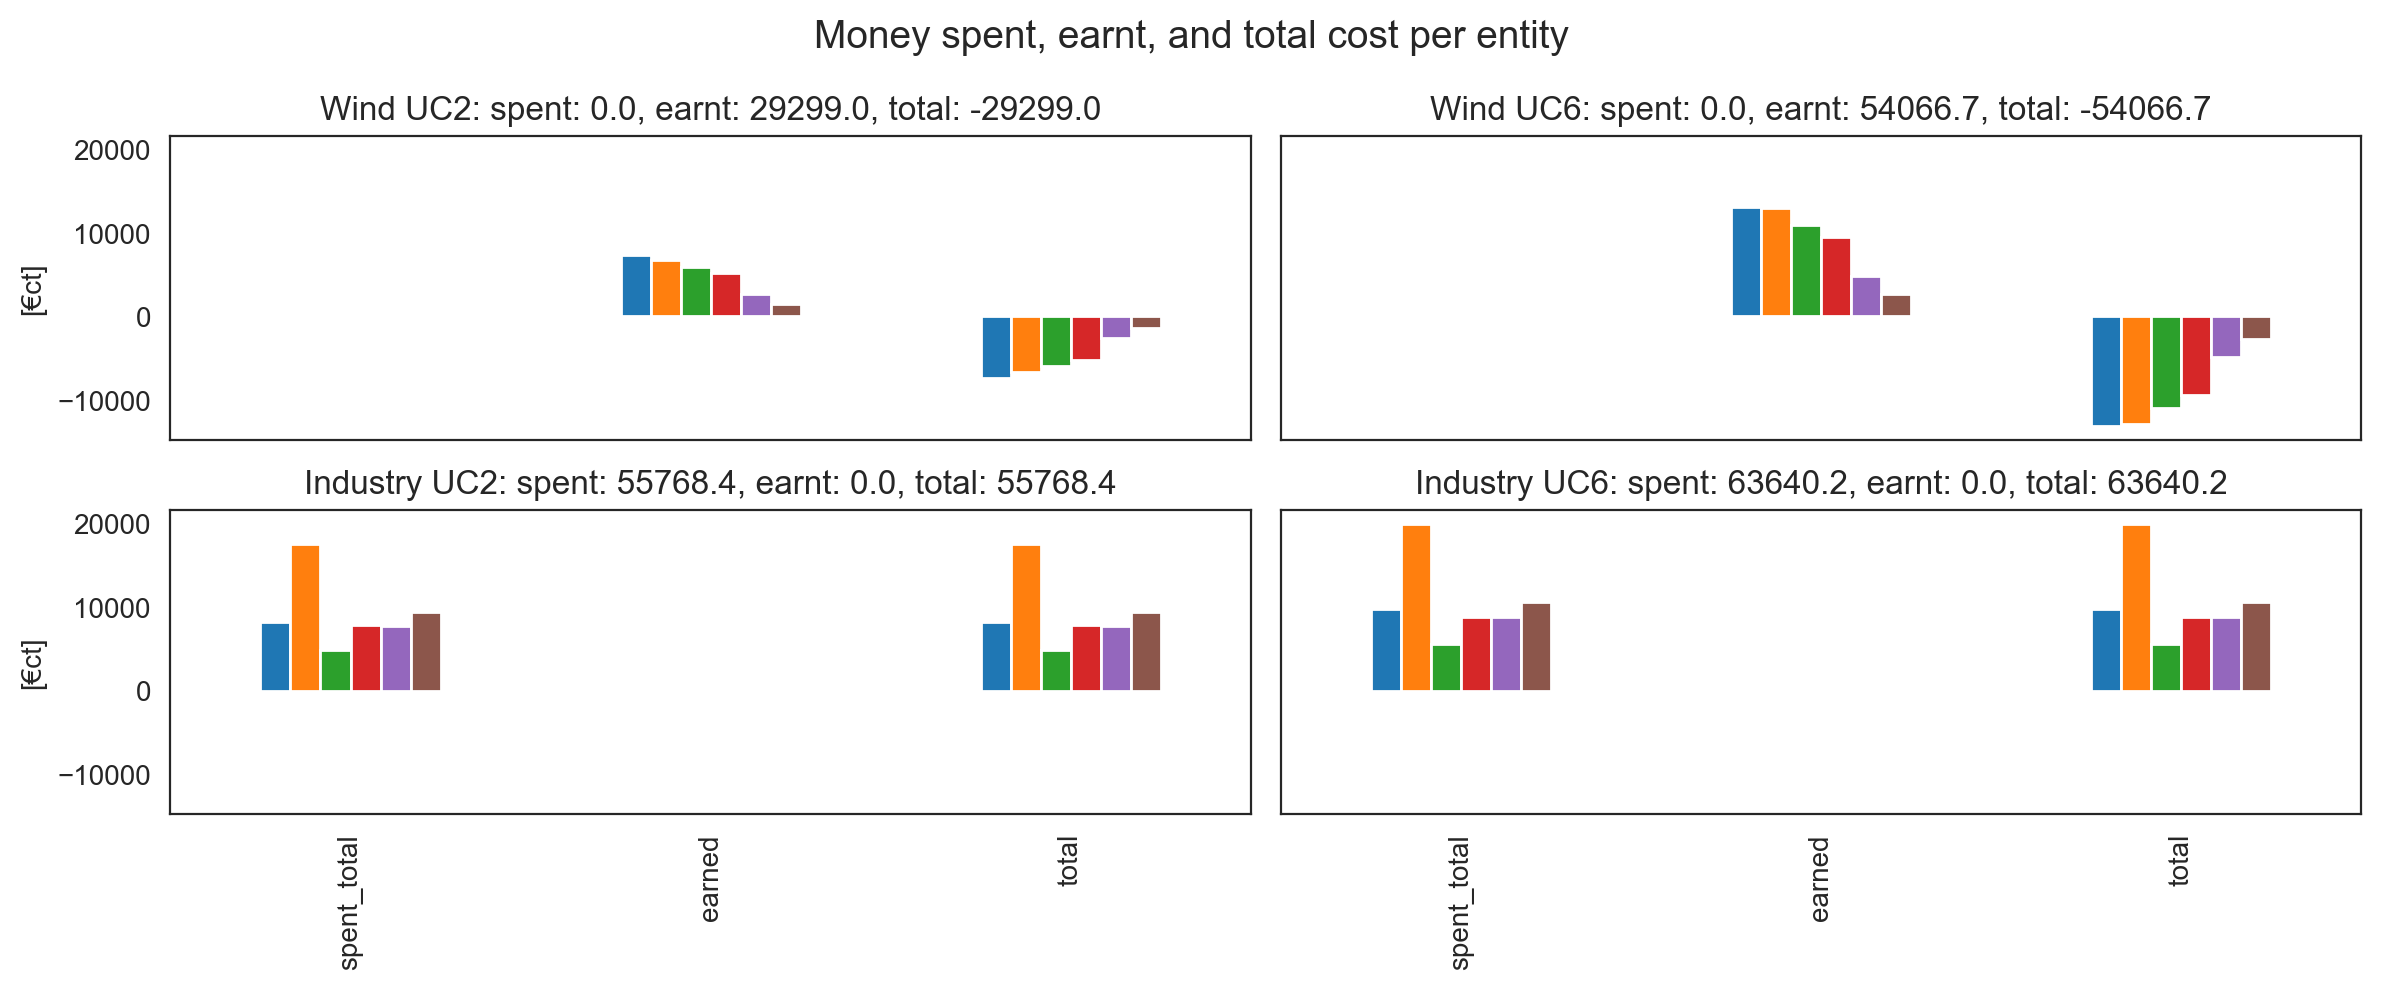

In [131]:
# Put all dataframes in 'dfs' that you want to plot on top of each other
df_dict = {
    'UC2': cum_bills_uc2,
    'UC6': cum_bills_uc6
}
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(2,2, figsize=(12,5), sharey=True, sharex=True)
fig.suptitle('Money spent, earnt, and total cost per entity', fontsize=14)

for i, key in enumerate(df_dict.keys()):
    df = df_dict[key]
    df_wind = df[[i for i in df.columns.tolist() if 'Wind' in i]]
    total_spent = np.round(df_wind.loc['spent_total'].sum(),1)
    total_earnt = np.round(df_wind.loc['earned'].sum(),1)
    total_total = np.round(df_wind.loc['total'].sum(),1)
    df_wind.plot(kind='bar', stacked=False, ax=axs[0,i], 
                 title=f'Wind {key}: spent: {total_spent}, earnt: {total_earnt}, total: {total_total}', legend=False)
    
    df_industry = df[[i for i in df.columns.tolist() if 'Industry' in i]]
    total_spent = np.round(df_industry.loc['spent_total'].sum(),1)
    total_earnt = np.round(df_industry.loc['earned'].sum(),1)
    total_total = np.round(df_industry.loc['total'].sum(),1)
    df_industry.plot(kind='bar', stacked=False, ax=axs[1,i], 
                 title=f'Industry {key}: spent: {total_spent}, earnt: {total_earnt}, total: {total_total}', legend=False)
    
axs[0,0].set_ylabel('[€ct]')
axs[1,0].set_ylabel('[€ct]')

plt.tight_layout()
plt.show()

---

##### Prosumer/Consumer split: Data preparation
For each use case, based on the directory path (e.g. `use_case_2_dir_path`) and the entities of the avg. trade rate and -volume dataframe (e.g. `df2`), we can access the corresponding `area_tree_summary.json` file and create a dataframe with all entities, adding a prosumer/consumer status depending on whether the household has a PV or not. The dataframe containing all entities (e.g. `df2`) is split into a prosumer and consumer dataframe (e.g. `prosumer_df_uc2` and `consumer_df_uc2`). These dataframes have the same structure as `df2`, but contain the entity columns of the respective category (prosumer/consumer).

The dataframes do not contain wind and industry, only households.

In [132]:
def get_prosumer_consumer_dfs(uc_path, df):
    # set up empty lists and all entities in grid
    month = 'apr'
    consumer, prosumer = [], []
    df_grid = pd.read_json(os.path.join(uc_path, month, 'area_tree_summary.json')).iloc[0,-1]

    # iterate over households, find prosumers and consumers based on presence of PV_FeedIn asset
    for region in df_grid['children']:
        for ec in region['children']:
            for house in ec['children']:
                if 'Industry' in house['name'] or 'Wind' in house['name']:
                    continue
                hh_assets = house['children']
                for asset in hh_assets:
                    if 'PV_FeedIn' in asset['name']:
                        prosumer.append(house['name'].lower())
                    else:
                        consumer.append(house['name'].lower())

    # filter out duplicates, make prosumer and consumer MECE
    prosumer = list(set(prosumer))
    consumer = list(set(consumer) - set(prosumer))

    # Filter columns for prosumer
    prosumer_columns = df.filter(regex='|'.join(prosumer)).columns

    # Filter columns for consumer
    consumer_columns = df.filter(regex='|'.join(consumer)).columns

    # Create new DataFrames with the filtered columns
    prosumer_df = df[prosumer_columns]
    consumer_df = df[consumer_columns]
    
    return prosumer_df, consumer_df


# get prosumer and consumer dfs for each use case (including wind and industry)
prosumer_df_uc2, consumer_df_uc2 = get_prosumer_consumer_dfs(use_case_2_dir_path, df2)
prosumer_df_uc6, consumer_df_uc6 = get_prosumer_consumer_dfs(use_case_6_dir_path, df6)

---

##### Prosumer/Consumer split: Data visualization

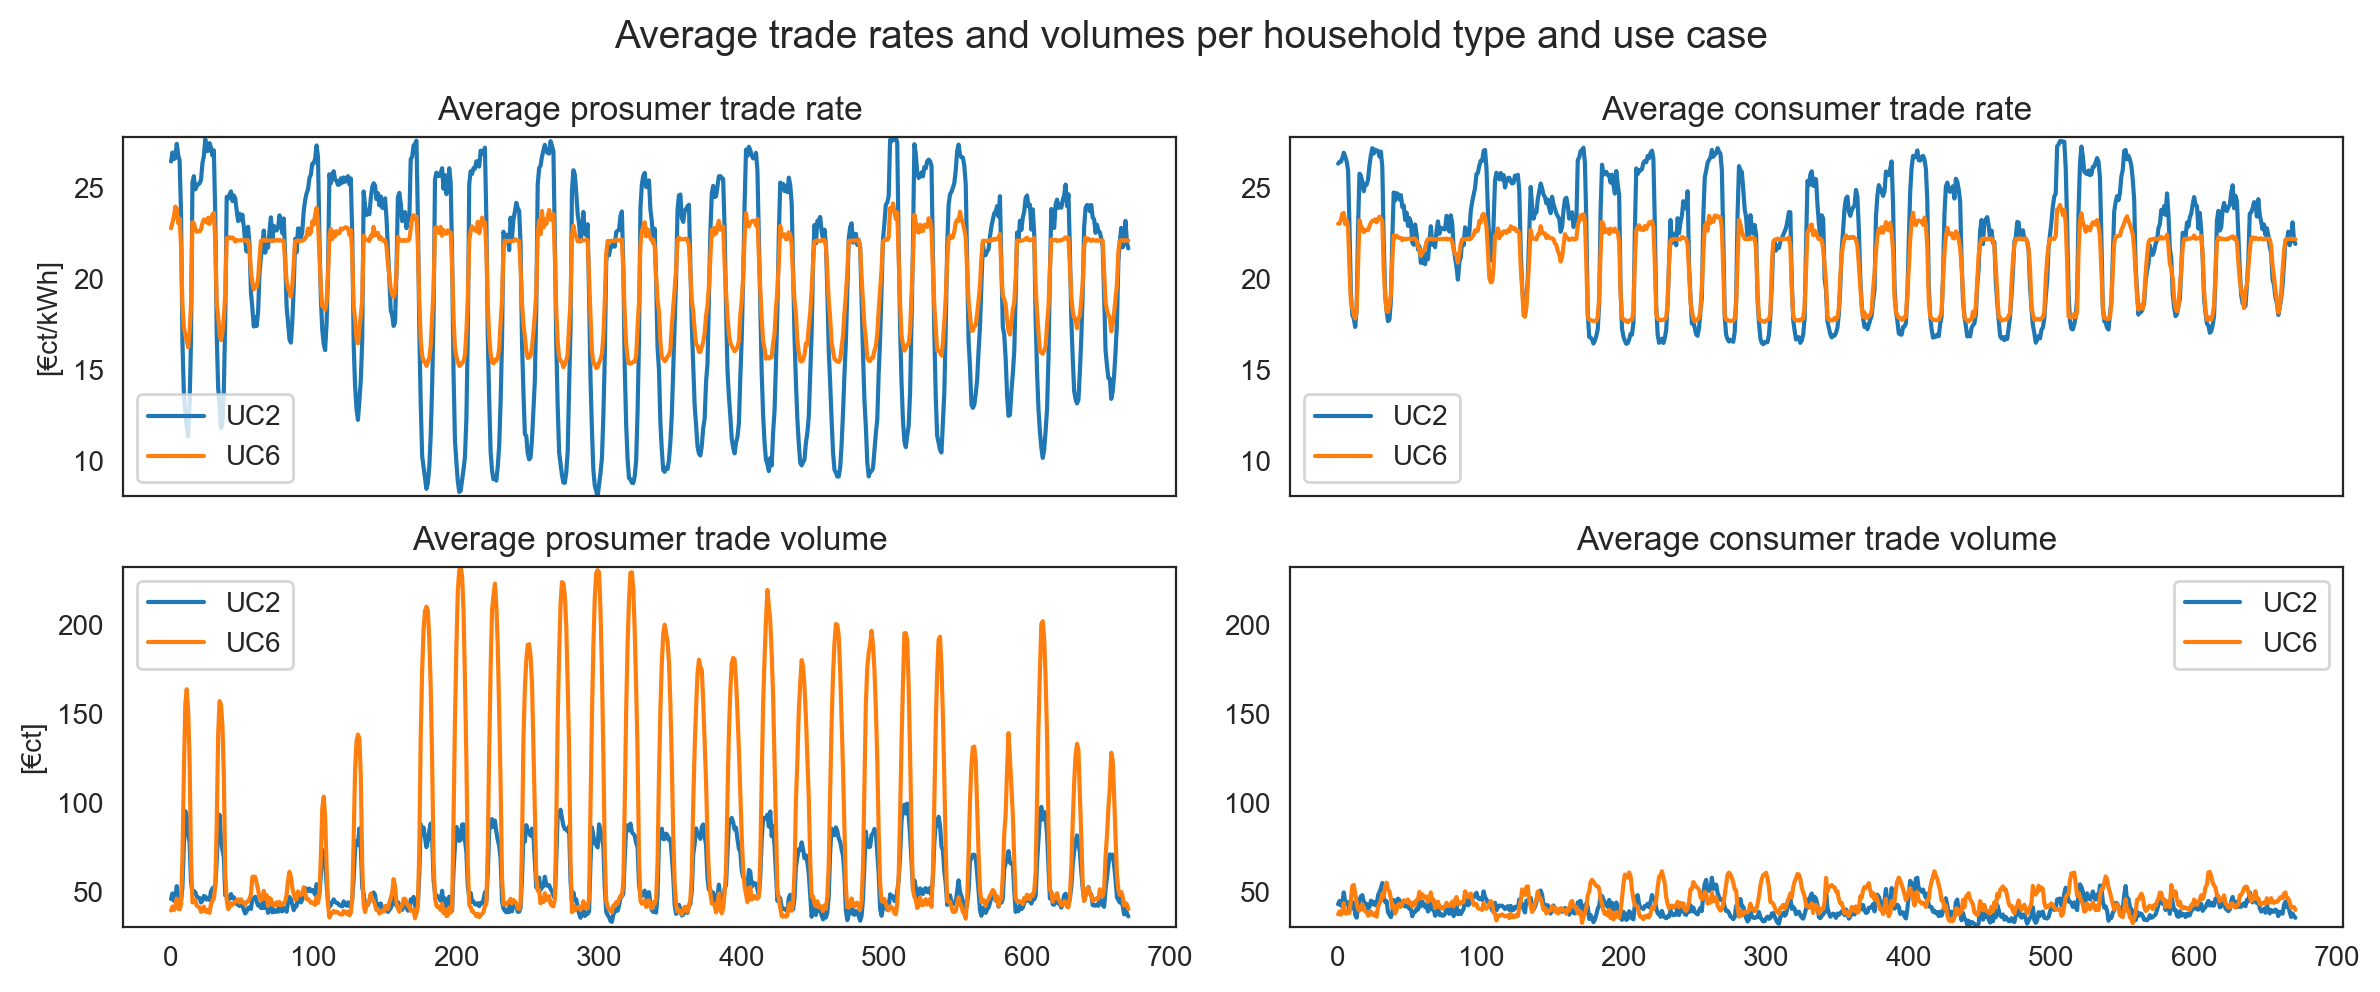

In [133]:
# plot
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(2,2, figsize=(12,5), sharey=False, sharex=True)
fig.suptitle('Average trade rates and volumes per household type and use case', fontsize=14)

axs[0,0].plot(prosumer_df_uc2.iloc[:,0::2].mean(axis=1), label='UC2')
axs[0,0].plot(prosumer_df_uc6.iloc[:,0::2].mean(axis=1), label='UC6')
axs[0,0].set_title('Average prosumer trade rate')
axs[0,0].set_ylabel('[€ct/kWh]')
axs[0,0].legend()

axs[0,1].plot(consumer_df_uc2.iloc[:,0::2].mean(axis=1), label='UC2')
axs[0,1].plot(consumer_df_uc6.iloc[:,0::2].mean(axis=1), label='UC6')
axs[0,1].set_title('Average consumer trade rate')
axs[0,1].legend()

axs[1,0].plot(prosumer_df_uc2.iloc[:,1::2].mean(axis=1), label='UC2')
axs[1,0].plot(prosumer_df_uc6.iloc[:,1::2].mean(axis=1), label='UC6')
axs[1,0].set_title('Average prosumer trade volume')
axs[1,0].set_ylabel('[€ct]')
axs[1,0].legend()

axs[1,1].plot(consumer_df_uc2.iloc[:,1::2].mean(axis=1), label='UC2')
axs[1,1].plot(consumer_df_uc6.iloc[:,1::2].mean(axis=1), label='UC6')
axs[1,1].set_title('Average consumer trade volume')
axs[1,1].legend()

# Set y-axis limits for each row
max_rate = max(prosumer_df_uc2.iloc[:,0::2].mean(axis=1).max(), prosumer_df_uc6.iloc[:,0::2].mean(axis=1).max(),
               consumer_df_uc2.iloc[:,0::2].mean(axis=1).max(), consumer_df_uc6.iloc[:,0::2].mean(axis=1).max())
min_rate = min(prosumer_df_uc2.iloc[:,0::2].mean(axis=1).min(), prosumer_df_uc6.iloc[:,0::2].mean(axis=1).min(),
               consumer_df_uc2.iloc[:,0::2].mean(axis=1).min(), consumer_df_uc6.iloc[:,0::2].mean(axis=1).min())
axs[0, 0].set_ylim([min_rate, max_rate])
axs[0, 1].set_ylim([min_rate, max_rate])

max_volume = max(prosumer_df_uc2.iloc[:,1::2].mean(axis=1).max(), prosumer_df_uc6.iloc[:,1::2].mean(axis=1).max(),
               consumer_df_uc2.iloc[:,1::2].mean(axis=1).max(), consumer_df_uc6.iloc[:,1::2].mean(axis=1).max())
min_volume = min(prosumer_df_uc2.iloc[:,1::2].mean(axis=1).min(), prosumer_df_uc6.iloc[:,1::2].mean(axis=1).min(),
               consumer_df_uc2.iloc[:,1::2].mean(axis=1).min(), consumer_df_uc6.iloc[:,1::2].mean(axis=1).min())
axs[1, 0].set_ylim([min_volume, max_volume])
axs[1, 1].set_ylim([min_volume, max_volume])

plt.tight_layout()
plt.show()

---

##### Flexible network charges: Data preparation
Based on the `tou_rate_dir` defined in the first cell of the notebook, we access the file containing 24h dynamic Time of Use (ToU) network tariffs. We then create another dataframe with the fixed rate (7.68€ct/kWh). For each use case, obtain the average trade rate for prosumers and consumers, respectively, and filter out data for the first 24h.

In [134]:
# read in TOU rates (used in use case 6)
tou_rates = pd.read_excel(os.path.join(tou_rate_dir, 'Input_Tou_UC5_final.xlsx'))

# create corresponding fixed rates (used in use case 2)
rate = 7.68
fixed_rates = pd.DataFrame({'network_rate': [rate] * len(tou_rates)})

##### Flexible network charges: Data visualization
Show the average trade rate for prosumers and consumers, together with the network tariff (fixed and dynamic) for the a 24h subset. In use case 2, the network tariff is fixed. In use case 6, the network tariff is dynamic (time of use).

You can set the `start_ctr` to select any day between 0 and 28.

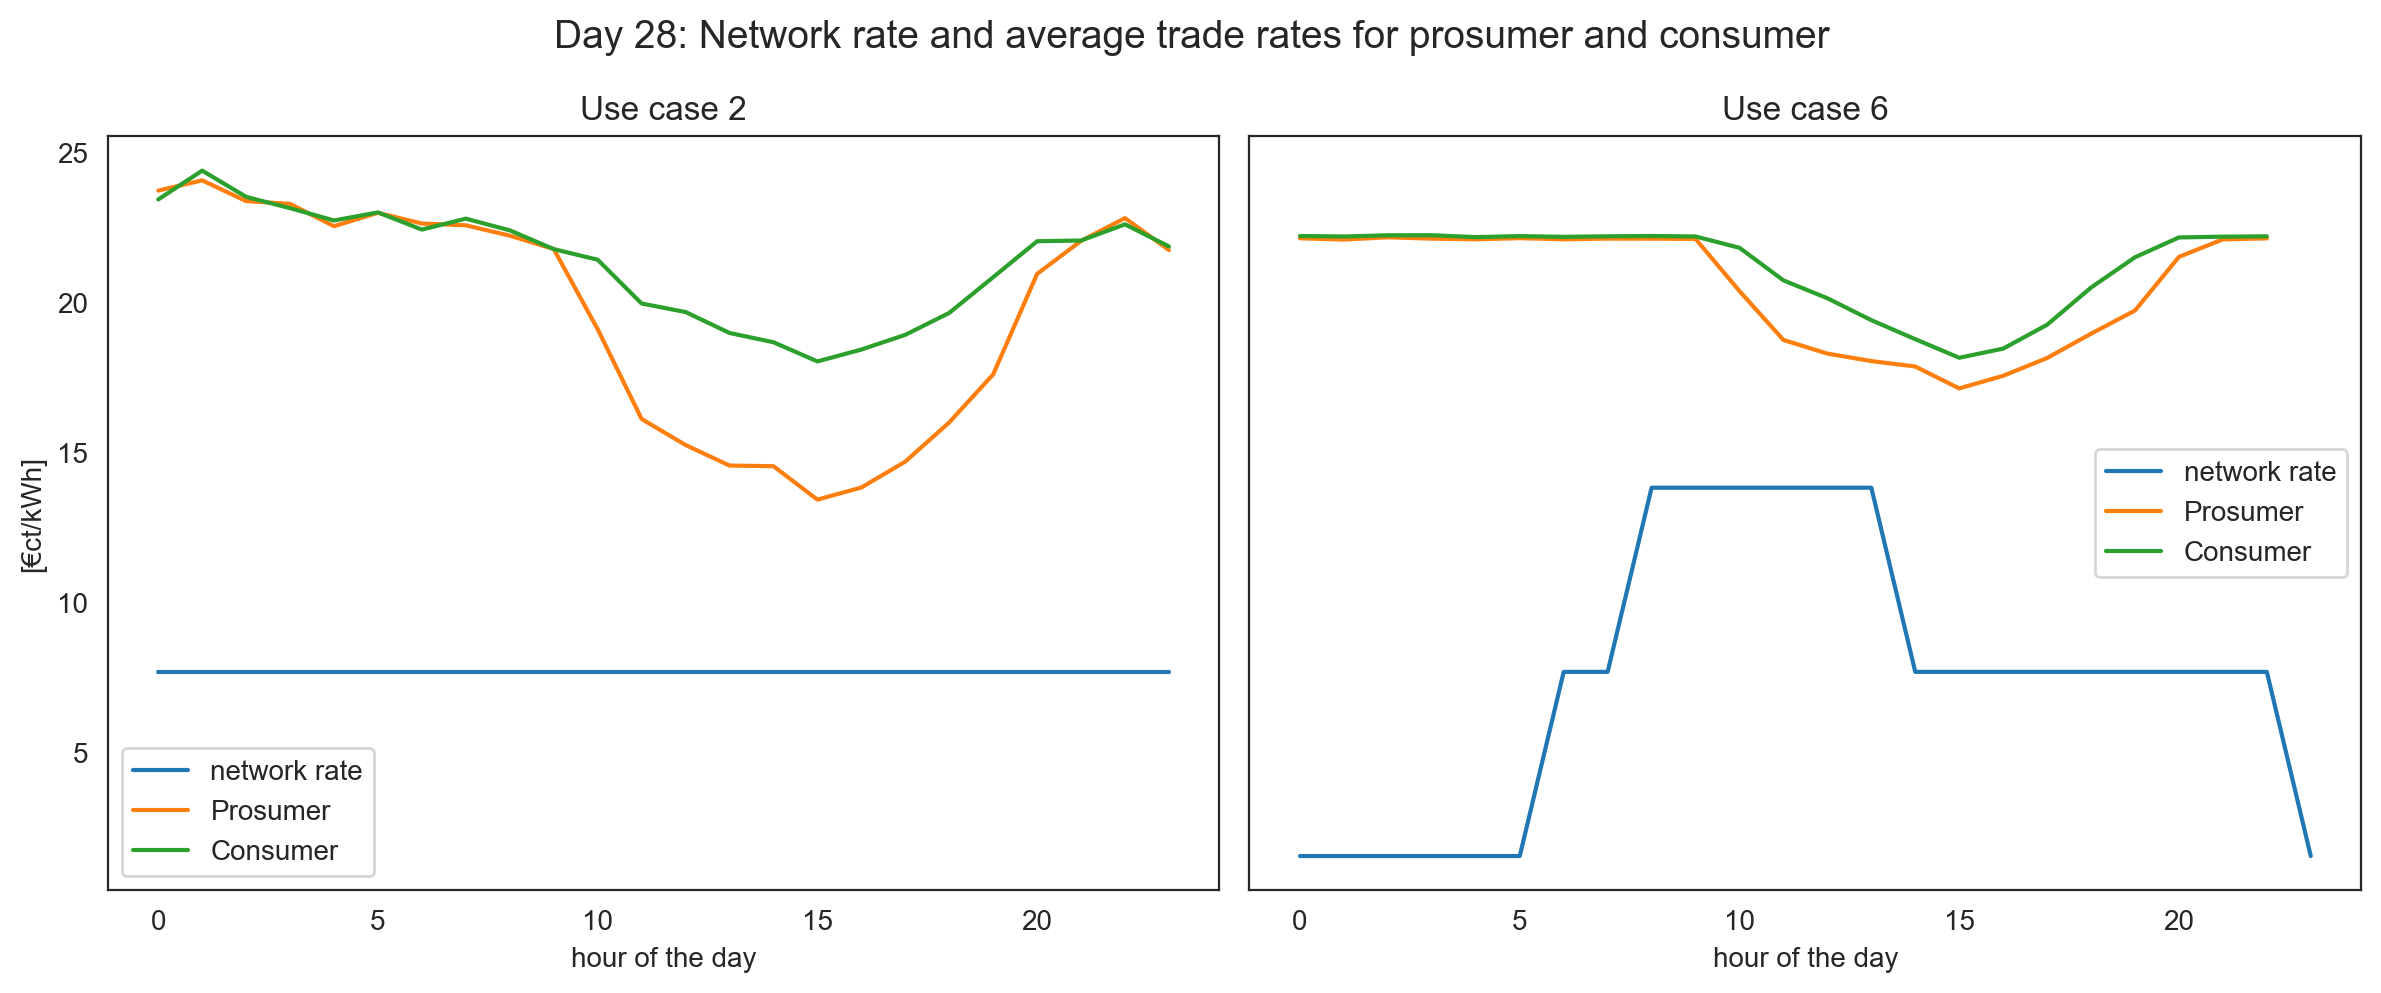

In [135]:
# set start counter for starting day (must be between 0 and 28)
start_ctr = 28

day_slice = len(tou_rates)-1

# use case 2: get average prices for prosumer and consumer for the first day
uc2_prosumer_avg_price_dayX = prosumer_df_uc2.iloc[:,0::2].mean(axis=1).loc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()
uc2_consumer_avg_price_dayX = consumer_df_uc2.iloc[:,0::2].mean(axis=1).loc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()

# use case 6: get average prices for prosumer and consumer for the first day
uc6_prosumer_avg_price_dayX = prosumer_df_uc6.iloc[:,0::2].mean(axis=1).iloc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()
uc6_consumer_avg_price_dayX = consumer_df_uc6.iloc[:,0::2].mean(axis=1).iloc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()

# plot
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)
fig.suptitle(f'Day {start_ctr}: Network rate and average trade rates for prosumer and consumer', fontsize=14)

# use case 2: plot average trade rates for prosumer and consumer for the first day, together with the fixed rate
axs[0].set_title('Use case 2')
axs[0].plot(fixed_rates.values, label='network rate')
axs[0].plot(uc2_prosumer_avg_price_dayX.values, label='Prosumer')
axs[0].plot(uc2_consumer_avg_price_dayX.values, label='Consumer')
axs[0].set_ylabel('[€ct/kWh]')
axs[0].set_xlabel('hour of the day')
axs[0].legend()

# use case 6: plot average trade rates for prosumer and consumer for the first day, together with the TOU rates
axs[1].set_title('Use case 6')
axs[1].plot(tou_rates.iloc[:,1].values, label='network rate')
axs[1].plot(uc6_prosumer_avg_price_dayX.values, label='Prosumer')
axs[1].plot(uc6_consumer_avg_price_dayX.values, label='Consumer')
axs[1].set_xlabel('hour of the day')
axs[1].legend()

plt.tight_layout()
plt.show()

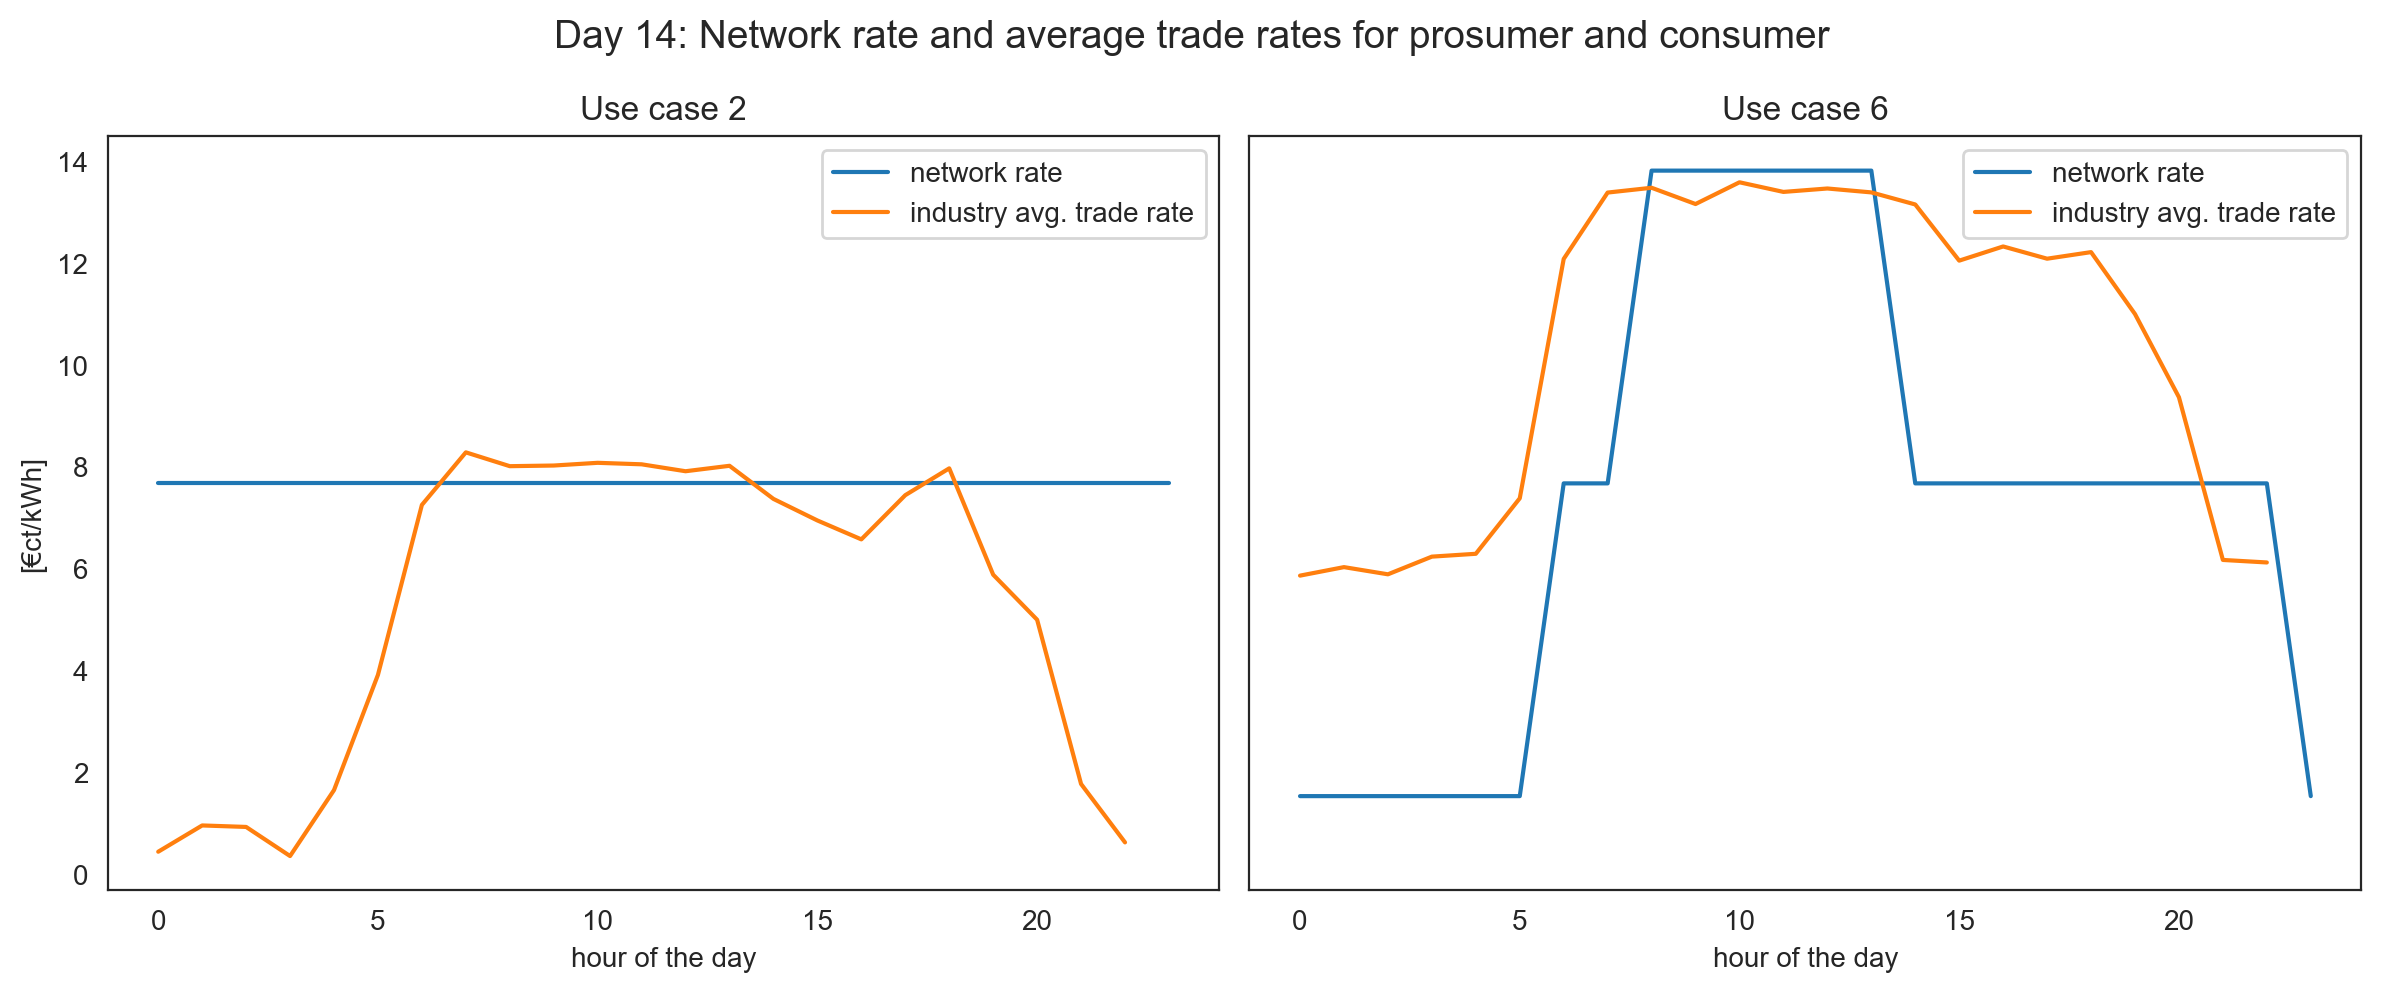

In [140]:
# set start counter for starting day (must be between 0 and 28)
start_ctr = 14
day_slice = len(tou_rates)-1

# plot
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)
fig.suptitle(f'Day {start_ctr}: Network rate and average trade rates for prosumer and consumer', fontsize=14)

# use case 2: plot average trade rates for prosumer and consumer for the first day, together with the fixed rate
df = df2
df_industry = df[[i for i in df.columns.tolist() if 'wind' in i]].iloc[:,0::2].mean(axis=1).iloc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()
axs[0].set_title('Use case 2')
axs[0].plot(fixed_rates.values, label='network rate')
axs[0].plot(df_industry.values, label='industry avg. trade rate')
axs[0].set_ylabel('[€ct/kWh]')
axs[0].set_xlabel('hour of the day')
axs[0].legend()

# use case 6: plot average trade rates for prosumer and consumer for the first day, together with the TOU rates
df = df6
df_industry = df[[i for i in df.columns.tolist() if 'industry' in i]].iloc[:,0::2].mean(axis=1).iloc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()
axs[1].set_title('Use case 6')
axs[1].plot(tou_rates.iloc[:,1].values, label='network rate')
axs[1].plot(df_industry.values, label='industry avg. trade rate')
axs[1].set_xlabel('hour of the day')
axs[1].legend()

plt.tight_layout()
plt.show()

In [137]:
df = df6
df_industry = df[[i for i in df.columns.tolist() if 'industry' in i]].iloc[:,0::2].mean(axis=1).iloc[day_slice * start_ctr:day_slice * (start_ctr+1)].to_frame()
df_industry.max()

0    23.62
dtype: float64

In [138]:
def get_battery_no_battery_dfs(uc_path, df):
    # set up empty lists and all entities in grid
    month = 'apr'
    battery, no_battery = [], []
    df_grid = pd.read_json(os.path.join(uc_path, month, 'area_tree_summary.json')).iloc[0,-1]

    # iterate over households, find prosumers and consumers based on presence of PV_FeedIn asset
    for region in df_grid['children']:
        for ec in region['children']:
            for house in ec['children']:
                if 'Industry' in house['name'] or 'Wind' in house['name']:
                    continue
                hh_assets = house['children']
                for asset in hh_assets:
                    if 'BatteryStorage' in asset['name']:
                        battery.append(house['name'].lower())
                    else:
                        no_battery.append(house['name'].lower())

    # filter out duplicates, make prosumer and consumer MECE
    battery = list(set(battery))
    no_battery = list(set(no_battery) - set(battery))

    # Filter columns for prosumer
    battery_columns = df.filter(regex='|'.join(battery)).columns

    # Filter columns for consumer
    no_battery_columns = df.filter(regex='|'.join(no_battery)).columns

    # Create new DataFrames with the filtered columns
    battery_df = df[battery_columns]
    no_battery_df = df[no_battery_columns]
    
    return battery_df, no_battery_df


# get prosumer and consumer dfs for each use case (including wind and industry)
battery_df_uc2, no_battery_df_uc2 = get_battery_no_battery_dfs(use_case_2_dir_path, df2)
battery_df_uc6, no_battery_df_uc6 = get_battery_no_battery_dfs(use_case_6_dir_path, df6)

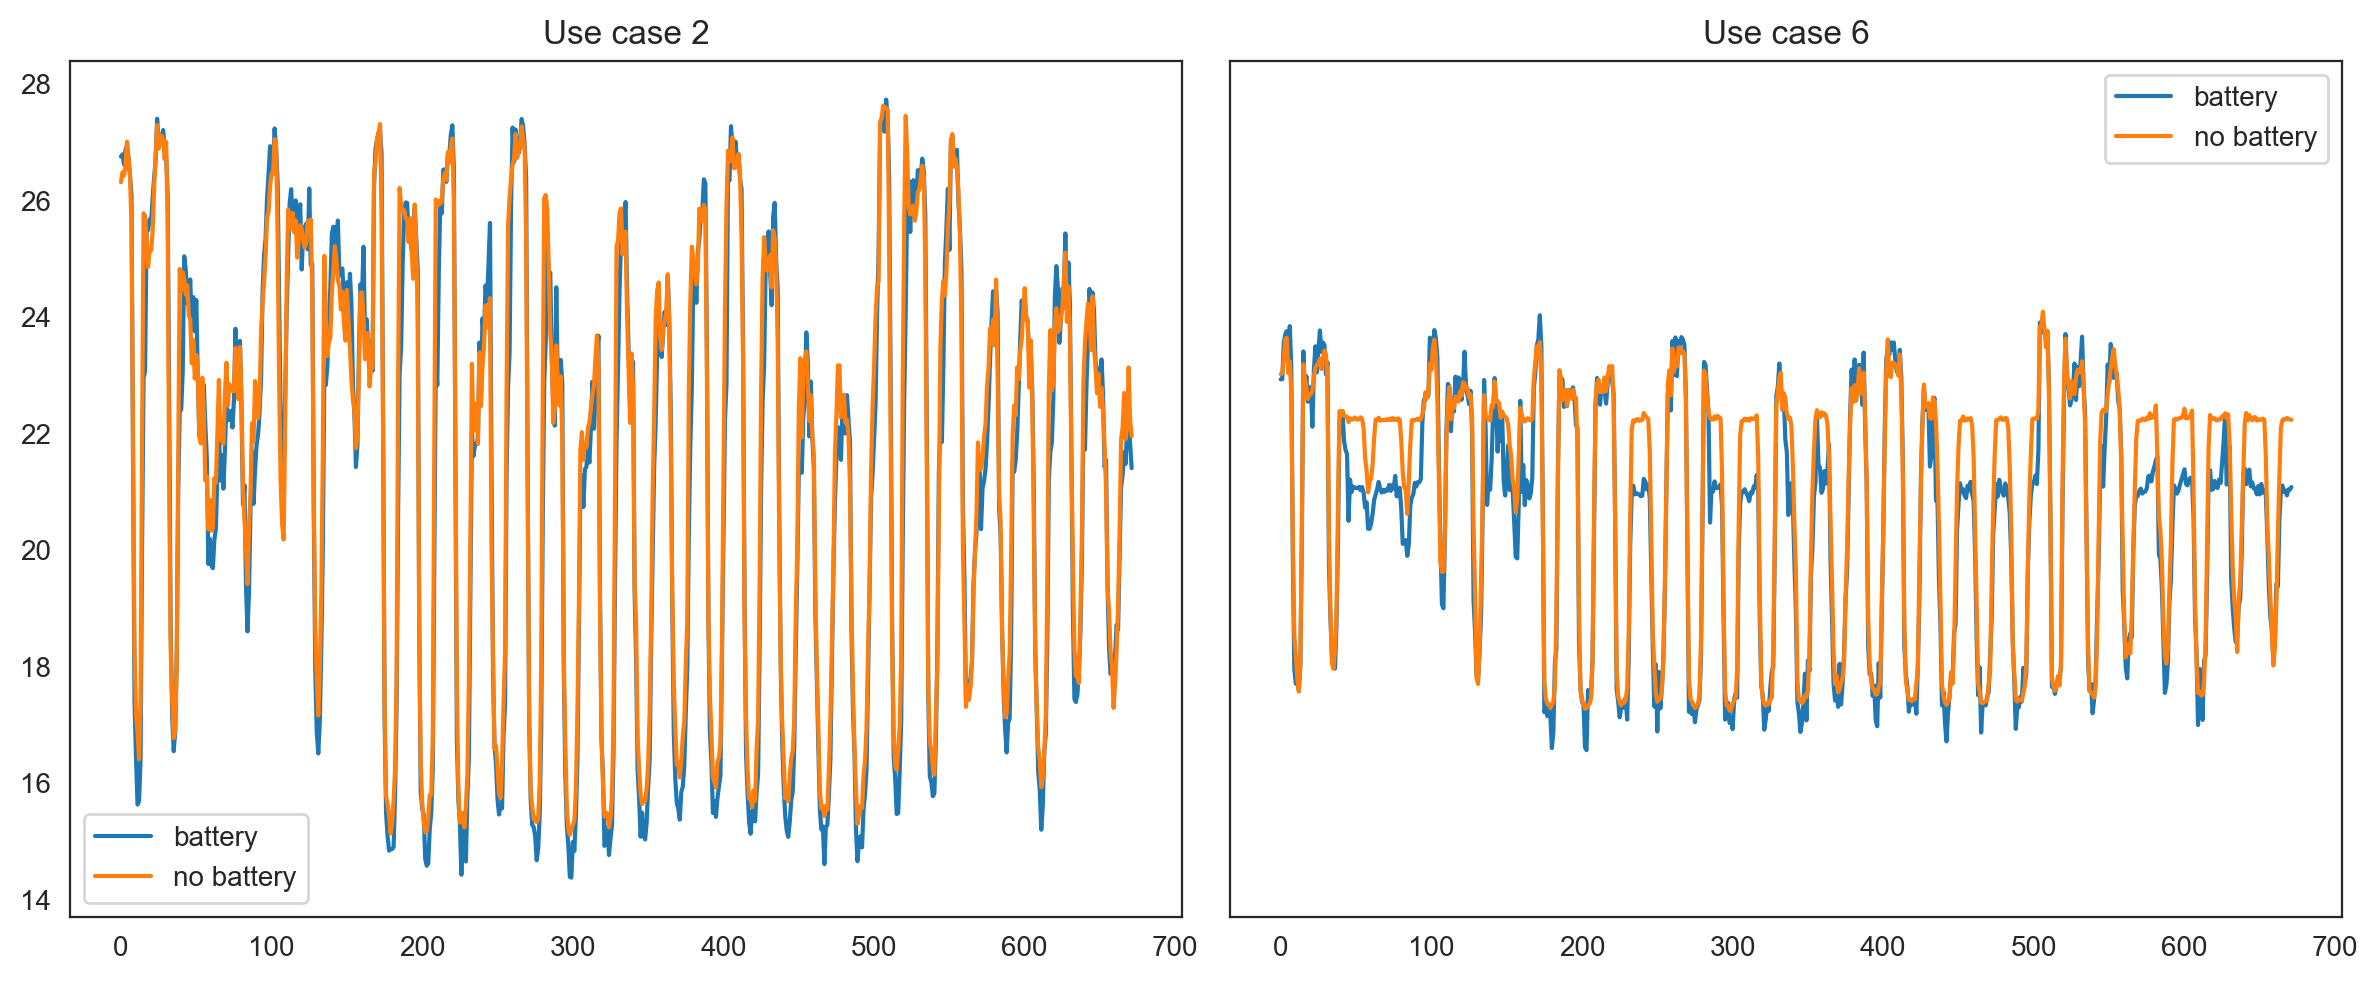

In [139]:
fig, axs = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

axs[0].set_title('Use case 2')
axs[0].plot(battery_df_uc2.iloc[:,0::2].mean(axis=1), label='battery')
axs[0].plot(no_battery_df_uc2.iloc[:,0::2].mean(axis=1), label='no battery')
axs[0].legend()

axs[1].set_title('Use case 6')
axs[1].plot(battery_df_uc6.iloc[:,0::2].mean(axis=1), label='battery')
axs[1].plot(no_battery_df_uc6.iloc[:,0::2].mean(axis=1), label='no battery')
axs[1].legend()

plt.tight_layout()
plt.show()